## Objective:  Identify PPG waveforms with artifacts based on these labeled data
-- Author:  Kirstin Aschbacher; Date:  April 2019

### About the Data
-- There are 1001 PPG waveforms, acquired from users of a commercially available App that uses the smartphone camers to acquire the PPG signals. Roughly 1 in 10 were hand-labeled as artifacts by visual inspection by a trained cardiologist (note: some signals labeled non-artifacts still have visual anomalies). The signals already underwent some preprocessing to eliminate baseline wander.
-- The data are given in NPY arrays: (if you load it as data, then data[0] will give you the PPG examples)
-- ''N' means normal - no artifact, 'H' means artifact
### About the Request
-- Find a heuristic or a *simple* model that uses FFT-derived frequency components to identify the artifacts
-- The resultant solution will be subsequently applied to evaluate whether cleaning a large dataset improves the fit of a different model applied to that dataset.  In other words, it evaluates whether cleaning up noise improves that model's performance.

In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import datetime as dt
import os
import sys
import logging
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True, precision=6, linewidth=500)
%matplotlib inline

# Pipeline Overview

In [2]:
# 0. Load data, visualize
# 1. Make power spectra (PS) scores (using FFT)
# 2. Visualize the differences in PS btw artifact vs non-artifact to provide intuition into discriminability
# 3. Feature Engineering: create additional features representing combinations of PS
# 4. Fit Logistic Regression Models, and select "best model" based on the single feature with maximal {recall, precision} in a hold-out test set
# 5. Contrast whether a LogReg that uses lasso to select amongst multiple features can perform better

### Load Data

In [3]:
%%time
DATA_FILE = 'artifact_data/ppg_artifacts_labelled.npy'# Location of data
data = np.load(DATA_FILE, encoding='bytes')
print (data[0].shape, type(data[0]), data[0][0].shape, type(data[0][0]))

(1001,) <class 'numpy.ndarray'> (2048,) <class 'numpy.ndarray'>
CPU times: user 56 ms, sys: 28.1 ms, total: 84.1 ms
Wall time: 104 ms


### Plot PPG data from one randomly selected user

40 [b'N'] (2048,)


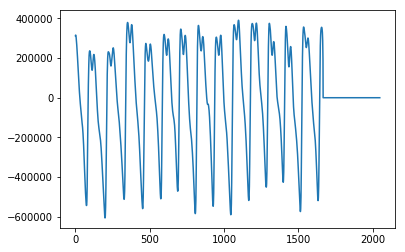

In [48]:
myid = np.random.choice( np.arange(len(data[0])) )# randomly select a user
plt.plot(data[0][myid])
#plt.ylim(1500000,-1500000)
print (myid, data[1][myid], data[0][myid].shape)

### Examples of Normal (green) and Artifact (magneta) PPG waveforms, according to the labels

![message](example_Artifact_PPG.jpeg "PPG signal labeled as Artifact")
![message](example_nonArtifact_PPG.jpeg "PPG signal labeled as Normal")

### 1. Define function to make Power Spectra Scores - top 10 frequencies

In [56]:
# This function calculates the power spectrum of an input signal  
# It returns the first 9 frequency components normalized to the fundemental frequency (total n_components=10)
# Thanks to my collaborator Zahra Karbaschi, PhD for consultation on the fft portion of this function

def get_power_spectrum(signal, sampling_freq, n_components):
    
    # Instantiate empty vectors
    freq_vec = np.zeros(n_components) #vector of freq ratios
    tmpvec = np.zeros((1, len(freq_vec)))
    
    # Define mathematical quantities
    assert sampling_freq>0 
    cycle_dur = 1.0/sampling_freq # Duration of one cycle in seconds. For example, 1/120Hz --> 0.00833 sec
    n_samples = signal.shape[0] # Number of samples in time domain
    signal_dur = n_samples*cycle_dur# Length of signal in sec
    pad = 0.5 #we "integrate" in the frequency domain around peaks by +/- 0.5 Hz
    epsilon = int(pad*signal_dur) #epsilon as a number of indices away from 1 Hz
    
    # Compute Power of spectral components; determine HR index
    ps = abs(np.fft.fft(signal))**2 #power spec
    heartRate_i = np.argmax(ps[epsilon:int(n_samples/2)]) + epsilon #index of the max peak, the HR (@ 1Hz)

    for i in range(1, n_components+1): #for each peak
        for j in range((i*heartRate_i)-epsilon, (i*heartRate_i)+epsilon): #integrate from over the peaks within +/- 0.5 Hz 
            freq_vec[i-1] += ps[j]
            
    assert freq_vec[0]!=0# Prevent divide by zero error. Also, first peak corresponds to HR, which should never be 0
    freq_vec /= freq_vec[0] #normalize all spectral components based on the first peak
    tmpvec[0] = freq_vec
    
    return tmpvec

### Implement Function

In [57]:
# Initialize Variables
n_components = 10# Number of power spectral components to extract
sampling_freq = 120# Sampling frequency of the signals in Hz

n_signals = data[0].shape[0]
power_spectra = np.zeros((n_signals, n_components))# shape=(n_signals, n_components)
signal = np.zeros((data[0][0].shape[0],))# a vector the length of one signal

# Loop over each user's data
for id in range(0, n_signals):
    signal = data[0][id]# np.array obj, shape (2048,)
    if signal.shape[0]>0:
        power_spectra[id] = get_power_spectrum(signal, sampling_freq, n_components)

### 2. Visualize how Artifacts and Non-Artifacts differ on the Power Spectral Components

In [ ]:
def get_artifacts(data):
    # ''N' means normal - no artifact, 'H' means artifact; You have 44 artifacts and 458 non-artifacts signals
    artifacts = [int(d[0].decode()=='H') for d in data[1]]
    print ('Total number of artifacts: {} and non-artifacts: {}'.format (np.sum(artifacts), len(artifacts)-np.sum(artifacts)))

    # Find indices of the artifacts
    art_idx = list(np.where(np.asarray(artifacts)==1))[0]
    ctr_idx = [i for i in range(0,len(artifacts)) if i not in art_idx]
    return [art_idx, ctr_idx]

In [ ]:
def group_stats(ps, groups):
    # Find the avg ps scores for artifacts and non-artifacts. These SEM are not pooled, they are by group
    assert (len(groups[0])>0) & (len(groups[1])>0)# Prevent divide by zero
    g0_mean = np.mean(ps[groups[0],:], axis=0)
    g1_mean = np.mean(ps[groups[1],:], axis=0)
    g0_sem = np.std(ps[groups[0],:], axis=0) / np.sqrt( len(groups[0]) )
    g1_sem = np.std(ps[groups[1],:], axis=0) / np.sqrt( len(groups[1]) )
    return [g0_mean, g1_mean],[g0_sem, g1_sem]

### 3A. Set a threshold for discrimination

In [ ]:
def get_thresholds(art_means, art_sems, n_sems):
    # define threshold of lower boundary on artifact group ps scores. Exclude 1st PS, which is 1 due to normalization
    thresh = [art_means[1:]-(n_sems*art_sems[1:])]
    print ('Determined {} thresholds at an SEM level of {}.\nThreshold values for PS[1,:]:\n{}'.format( len(thresh[0]), n_sems, thresh ) )
    return thresh

In [ ]:
def plot_groups(means, sems, thresh):
    # Plot the average scores by artifact group, to see whether there's an obvious difference
    art_m, ctr_m = means
    art_err, ctr_err = sems
    
    # Plot the threshold for determining when an artifact is an error
    #thresh = [means[0][1:5]-(2*sems[0][1:5])]
    plt.scatter(list(np.arange(1,len(thresh[0])+1)),thresh, color='g')
    
    plt.errorbar(x=np.arange(len(art_m)), y=art_m, yerr=art_err, color='r')
    plt.errorbar(x=np.arange(len(ctr_m)), y=ctr_m, yerr=ctr_err, color='b')
    
    plt.legend(['threshold','artifacts','non-artifacts'])
    plt.title('Normalized PPG Power Spectra (FFT) by Artifact Group', fontsize=14)
    plt.show()

### Implement Functions Above

In [ ]:
groups = get_artifacts(data)# returns a list of indices for artifacts and non-art: [art_idx, ctr_idx]
means, sems = group_stats(power_spectra, groups)# returns the means and sems on ps for the groups

art_means = means[0]
art_sems = sems[0]
thresh = get_thresholds(art_means, art_sems, SE_THRESHOLDS)

plot_groups(means, sems, thresh)
#print (means, sems)

### 3B. Apply threshold

In [ ]:
def get_group_labels(data):
    # Make a new column vector of true labels that is numeric (0=non-artifact, 1=artifact)
    temp = [int(label[0].decode()=='H') for label in data[1]]
    labels = np.asarray(temp)
    return labels

In [ ]:
def get_thresholded_ps(power_spectra, thresh, ub):
    # ub should be the last power_spectra component you want to include. 
    # Thresholds exclude 1st (0-indexed component)
    t = np.asarray(thresh).reshape(-1,1)
    #print (power_spectra.shape, t.shape)
    ps = (power_spectra[:, 1:ub+1]>t[1, :ub]).astype(int)
    return ps

## Make tps (thresholded power spectra)

In [ ]:
# Get actual labels as boolean vector
labels = get_group_labels(data)

tps = get_thresholded_ps(power_spectra, thresh, 6)#include power spectra 1-6 or indices [1:7]
#tps = power_spectra[:, 1:7]# HACK

# Qualitatively compare predicted to actual - Visually QA
for i in range(6, 10):
    print (labels[i], ': ', tps[i], np.sum(tps[i]))

### 4. Create the Feature Matrix
<p>A. Get all combinations of power spectra indices</p>
<p>B. Compute sums across each combination</p>
<p>C. Create modifications of sums --> any, sqrt, **2</p>
<p>D. Stack all the features into one master matrix</p>

In [ ]:
# Given a set of power spectra (excluding the 1st or 0-indexed ps, to which others are normalized...)
# Generate all the possible combinations of the indices for those ps, and sum over those
# For example, given 4 ps... we would find 4C2, 4C3, and 4C4 total combinations.

In [ ]:
def get_combinations(arr):
    n = arr.shape[1]# Number of power spectra that we applied thresholds to, and want to include in this exercise
    idx_list = np.arange(0, n)# A list of the indices we can choose from
    idx_comb = []# A list of all the combinations of indices we will use to make sums

    # First build idx_comb, by looping over the k in nCk (i.e., the number of items we choose)
    for k in range(2, n+1):
        temp = list(itertools.combinations(idx_list, k))
        idx_comb.extend(temp)
    return idx_comb

In [ ]:
def get_sums(arr, idx_comb):
    # Create sums using combination list
    sums = np.zeros((arr.shape[0], len(idx_comb)))
    # Loop over combinations and compute sum
    for i, c in enumerate(idx_comb):
        sums[:, i] = arr[:, list(c)].sum(axis=1)
    return sums

In [ ]:
def stack_sums(sums):
    stack = {'sums': sums}
    # Create any, sqrt, sq
    stack['anyy'] = (sums>0).astype(int)
    stack['sqrtt'] = np.sqrt(sums)# should be no negative values in sums...
    stack['sq'] = sums**2
    return stack

In [ ]:
def make_feature_arr(arr, stack):
    
    # Set Variables
    f0 = arr.shape[1]# number of power spectra in arr
    f1 = stack['sums'].shape[1]# number of combinations
    print ( 'Number of features in original array: {}'.format(f0) )
    stacks = ['sums', 'anyy', 'sqrtt', 'sq']
    features = np.zeros( (stack['sums'].shape[0], f0 + (4*f1)) )
    
    # Stack up final features array
    features[:, :f0] = arr
    for i in range(0,4):
        features[:, f0+(f1*i): f0+(f1*(i+1))] = stack[stacks[i]]
    print ( 'Number of features in final features array: {}, after adding 4*n_comb: sums, any, sqrt, sq'.format(features.shape[1]) )
    return features

#### Get the feature matrix --> apply functions above

In [ ]:
def get_features(arr):

    # Get combination list
    idx_comb = get_combinations(arr)
    print ('Number of combinations: {}'.format(len(idx_comb)))

    # Create sums using combination list
    sums = get_sums(arr, idx_comb)
    stack = stack_sums(sums)

    # Stack up final features array
    return make_feature_arr(arr, stack), idx_comb, stack

features, idx_comb, stack = get_features(power_spectra[:, 1:7])
total_cols = tps.shape[1]+4*len(idx_comb)# How total n_features is derived
assert total_cols==features.shape[1]

print (features.shape)
print (stack['sums'].shape, stack['sqrtt'].shape)

### How Correlated are the features?

In [ ]:
corr = pd.DataFrame(features[:,:tps.shape[1]]).corr()# Just illustrate the original thresholded PS
sns.heatmap(corr, annot=True)

### 5. Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def fit_model(X_train, X_test, y_train, y_test):
    reg = LogisticRegression(fit_intercept=True, class_weight='balanced', solver='lbfgs', \
                         random_state=7, verbose=0).fit(X_train, y_train) 
    return reg

In [ ]:
def summarize(scores):
    print('Test set Accuracy: {:.02f}%, Recall: {:.02f}%, Precision: {:.02f}%, F1: {:.02f}%\
        '.format(100*scores[0], 100*scores[1], 100*scores[2], 100*scores[3]))

In [ ]:
def confuse_me(reg, X_test, y_test):
    # Predictions -->Confusion Matrix 
    y_pred = reg.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)# true, predicted
    
    # Evaluate Model
    accuracy = reg.score(X_test, y_test)
    recall = cm[1][1]/np.sum(cm[1,:])
    precision = cm[1][1]/np.sum(cm[:,1])
    F1 = 2 * (precision * recall) / (precision + recall)
    scores = [accuracy, recall, precision, F1]
    #summarize(scores)
    return cm, scores

In [ ]:
def plot_cm(cm, scores):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label') 
    plt.title('Accuracy Score: {:2f}%'.format(100*scores[0]), size = 13);
    plt.show()

In [ ]:
def plot_ROC(fpr, tpr):
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(fontsize=14)
    plt.show()

### 5. Fit Many Models: Single factor Logistsic Regression
If we manually look at these different single predictors, and judge based on optimizing recall...
The best recall is obtained with the first sum (i.e., the first two components are both above the threshold)

In [ ]:
# Instantiate new arrays
X = np.zeros((features.shape[0],1))
y = np.zeros((features.shape[0],1))

# Choose how many features to examine
n_features = features.shape[1]
#n_features = 50

# Build results to rank
result_headers = ['combination','stack_type','accuracy', 'recall', 'precision', 'F1', 'tn', 'fn', 'fp', 'tp']
results = []
n_tps = tps.shape[1]# number of single thresholded power spectra included
n_comb = len(idx_comb)# number of combinations used to form sums, anyy, sqrt, sq
stack_keys = list(stack.keys())

# Loop over each feature, fit a logistic regression model
for i in range(n_features):
    # Define Features/Outcome & Partitions
    X = features[:, i].reshape(-1, 1)# Test set Accuracy: 89.76%, Recall: 78.57%, Precision: 44.00%
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Evaluate
    reg = fit_model(X_train, X_test, y_train, y_test)
    cm, scores = confuse_me(reg, X_test, y_test)
    
    # Add Results
    def tup_to_str(tup):
        return ','.join([str(t) for t in tup])

    # Append a string to a list, or a list to a list;  extend to add a list to another list
    temp = []
    if i<n_tps:
        temp.append( tup_to_str( (i,) ) )# add single spectra to the list of combination tuples
        temp.append('single')
    else:
        # Add the combination as a string
        comb_idx = (i-n_tps)%n_comb# index of the correct combination. Shift left by 6 (single ps), cycle by n_combinations
        stack_i = (i-n_tps)//n_comb# n times divides by
        temp.append( idx_comb[comb_idx] )# add the combination tuple
        temp.append(stack_keys[stack_i])
        #print (idx_comb[comb_idx])# DEBUG

    temp.extend(scores)
    temp.extend(cm.flatten('F'))
    results.append(temp)

res_df = pd.DataFrame(results, columns=result_headers)
print ('Shape of results: ', res_df.shape)
res_df.head(10)

### 6. Find Best Model

In [ ]:
# Find Best Result
res_df.sort_values(['recall','precision','accuracy'], ascending=False, inplace=True)
#res_df.sort_values(['F1','recall','precision','accuracy'], ascending=False, inplace=True)
best_model_idx = res_df.index.tolist()[0]
print ('Best results for row:', best_model_idx)
display(features[:, best_model_idx])
res_df.head(5)

### QA Check Model Validity & Save Model Object
-- when we input just the best_model_idx feature to the logreg, we should get the exact same results as above

In [ ]:
from sklearn.externals import joblib
# Define Features/Outcome & Partitions
X = features[:, best_model_idx].reshape(-1, 1)# Test set Accuracy: 89.76%, Recall: 78.57%, Precision: 44.00%
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Evaluate
reg = fit_model(X_train, X_test, y_train, y_test)
cm, scores = confuse_me(reg, X_test, y_test)

summarize(scores)
plot_cm(cm, scores)

# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(reg, filename)

In [ ]:
### ROC Curve - not working - something about reshaping cm
y_proba = reg.predict_proba(X_test)[:,1].reshape(-1,1)
y_true = y_test.reshape(-1,1)

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba)#pos_label='Artifacts'
roc_auc = metrics.auc(fpr, tpr)

# Plot w/ Matplotlib
plot_ROC(fpr, tpr)

# Plot w/ ggplot
# df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# gg = ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')
# gg + theme_bw()

### 7. Fit Logistic Regression Model with many features

In [ ]:
# %%time
# X = features[:, :].copy()
# y = labels

# # Partition
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# # Evaluate
# lasso = LogisticRegression(fit_intercept=True, class_weight='balanced', penalty='l1', solver='saga', \
#                          random_state=7, verbose=2, n_jobs=-1, \
#                             tol=1e-6, max_iter=int(1e4), warm_start=True).fit(X_train, y_train) 

### Surprisingly (?), this doesn't do better when LogReg is given many features and selects w/ lasso

In [ ]:
# cm, scores = confuse_me(lasso, X_test, y_test)
# print (cm)
# summarize(scores)
# plot_cm(cm, scores)